# Load Claims Data and build a Fraud Prevention Model

This tutorial provides examples of how to use CSV data with TensorFlow.

There are two main parts to this:

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

This tutorial focuses on the loading, and gives some quick examples of preprocessing. To learn more about the preprocessing aspect, check out the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.


## Setup

In [1]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

## Mixed data types

The raw data can easily be loaded as a Pandas `DataFrame`, but is not immediately usable as input to a TensorFlow model.


In [3]:
titanic = pd.read_csv("/content/sample_data/fraud_oracle.csv",
#                      usecols=['Month','WeekOfMonth','DayOfWeek','Make','AccidentArea','DayOfWeekClaimed','MonthClaimed','Sex','MaritalStatus','Age',
#                             'Fault','PolicyType','VehicleCategory','VehiclePrice','FraudFound_P','Deductible','DriverRating',
#                             'PastNumberOfClaims','AgeOfVehicle','PoliceReportFiled','WitnessPresent','AgentType','NumberOfSuppliments','NumberOfCars']
)
titanic.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
# titanic_features = titanic.copy()
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('FraudFound_P')

In [5]:
titanic_features.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [6]:
titanic_labels.head()

0    0
1    0
2    0
3    0
4    0
Name: FraudFound_P, dtype: int64

Because of the different data types and ranges, you can't simply stack the features into a NumPy array and pass it to a `tf.keras.Sequential` model. Each column needs to be handled individually.

As one option, you could preprocess your data offline (using any tool you like) to convert categorical columns to numeric columns, then pass the processed output to your TensorFlow model. The disadvantage to that approach is that if you save and export your model the preprocessing is not saved with it. The Keras preprocessing layers avoid this problem because they're part of the model.


In this example, you'll build a model that implements the preprocessing logic using [Keras functional API](https://www.tensorflow.org/guide/keras/functional). You could also do it by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build a representation of the calculation, that you can run later. Here's a quick example:

In [7]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [8]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [9]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


To build the preprocessing model, start by building a set of symbolic `tf.keras.Input` objects, matching the names and data-types of the CSV columns.

In [10]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'Month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Month')>,
 'WeekOfMonth': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'WeekOfMonth')>,
 'DayOfWeek': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'DayOfWeek')>,
 'Make': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Make')>,
 'AccidentArea': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'AccidentArea')>,
 'DayOfWeekClaimed': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'DayOfWeekClaimed')>,
 'MonthClaimed': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MonthClaimed')>,
 'WeekOfMonthClaimed': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'WeekOfMonthClaimed')>,
 'Sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 'MaritalStatus': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MaritalStatus')>,
 'Age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'A

The first step in your preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [11]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'normalization')>

Collect all the symbolic preprocessing results, to concatenate them later:

In [12]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `tf.keras.layers.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `tf.keras.layers.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model.

The default settings for the `tf.keras.layers.CategoryEncoding` layer create a one-hot vector for each input. A `tf.keras.layers.Embedding` would also work. Check out the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial for more on this topic.

In [13]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

With the collection of `inputs` and `preprocessed_inputs`, you can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

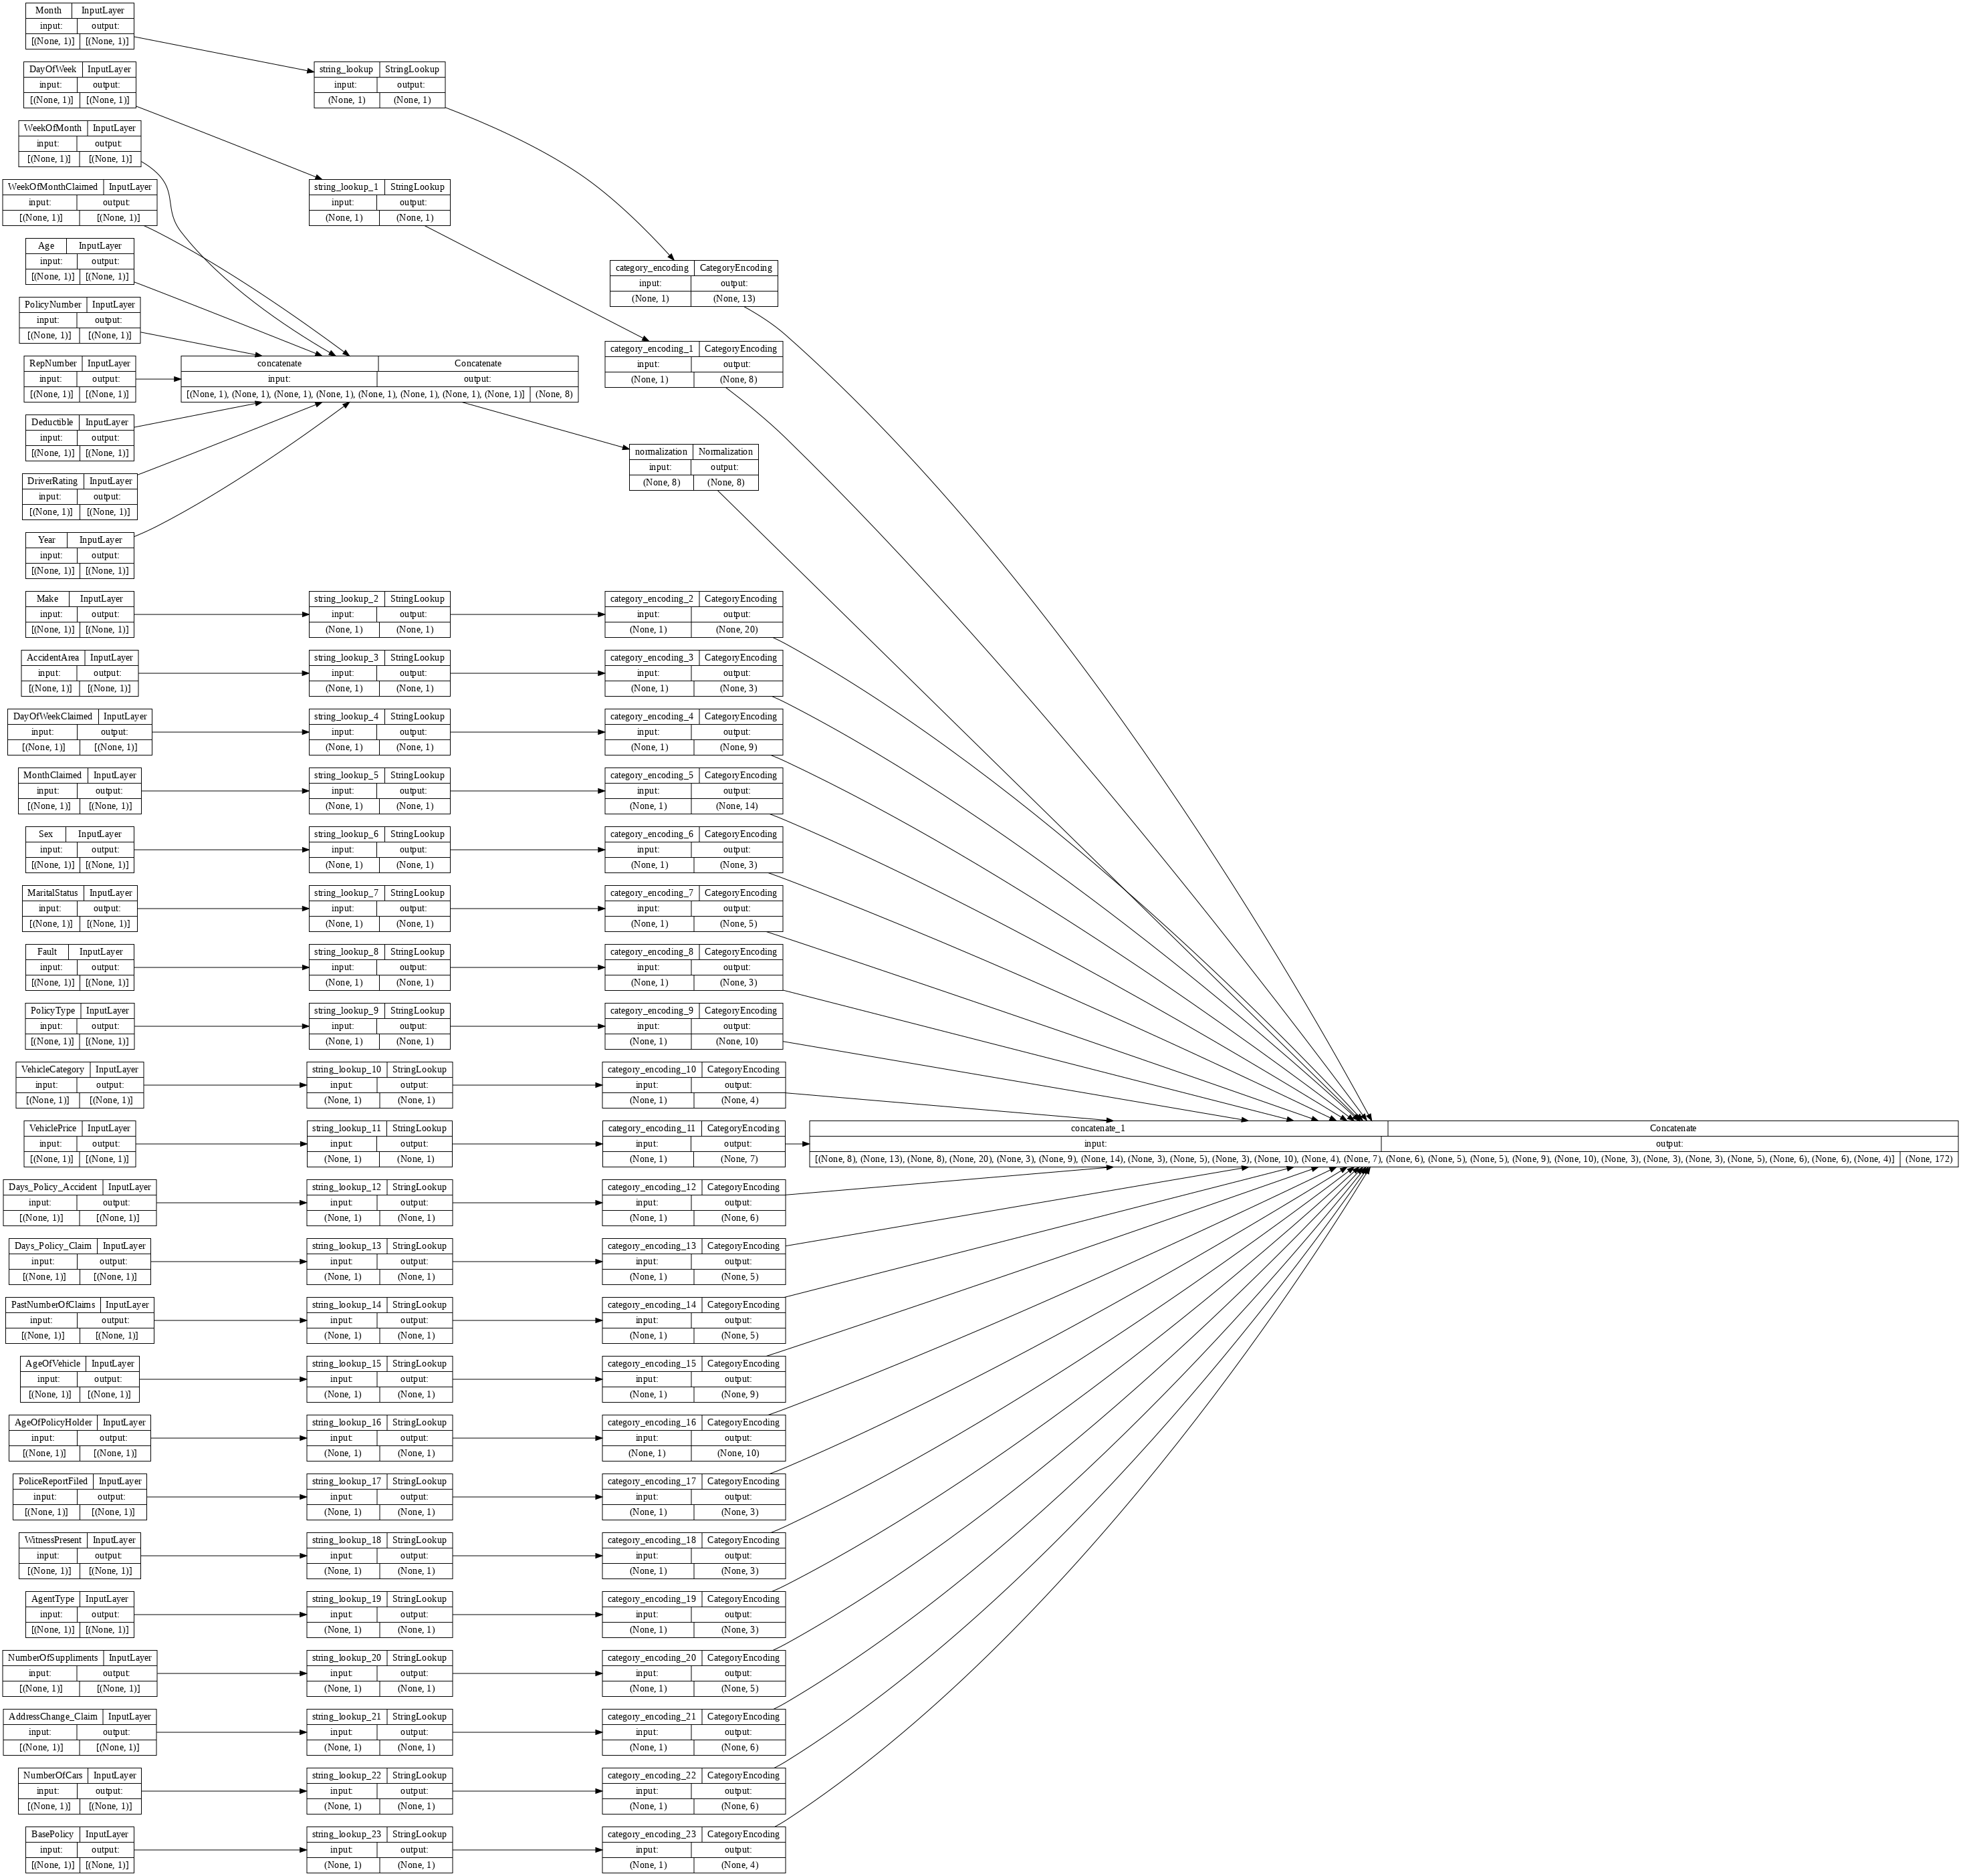

In [14]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

This model just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert pandas `DataFrame`s because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So, convert it to a dictionary of tensors:

In [15]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

Slice out the first training example and pass it to this preprocessing model, you see the numeric features and string one-hots all concatenated together:

In [18]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 172), dtype=float32, numpy=
array([[ 1.718, -1.345, -1.398, -1.732,  0.765, -2.451, -1.329, -1.079,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  1.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   

Now, build the model on top of this:

In [19]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy','Precision','Recall'])
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [20]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, batch_size = 25, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


617/617 [==============================] - 8s 8ms/step - loss: 0.2084 - Accuracy: 0.9373 - precision: 0.0417 - recall: 0.0022
Epoch 2/100
617/617 [==============================] - 5s 8ms/step - loss: 0.1883 - Accuracy: 0.9401 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/100
617/617 [==============================] - 5s 7ms/step - loss: 0.1824 - Accuracy: 0.9403 - precision: 0.6667 - recall: 0.0043
Epoch 4/100
617/617 [==============================] - 4s 7ms/step - loss: 0.1737 - Accuracy: 0.9406 - precision: 0.6400 - recall: 0.0173
Epoch 5/100
617/617 [==============================] - 4s 7ms/step - loss: 0.1687 - Accuracy: 0.9412 - precision: 0.6491 - recall: 0.0401
Epoch 6/100
617/617 [==============================] - 4s 7ms/step - loss: 0.1587 - Accuracy: 0.9425 - precision: 0.6581 - recall: 0.0834
Epoch 7/100
617/617 [==============================] - 4s 7ms/step - loss: 0.1528 - Accuracy: 0.9440 - precision: 0.6875 - recall: 0.1192
Epoch 8/100
617/617 [=================

Since the preprocessing is part of the model, you can save the model and reload it somewhere else and get identical results:

In [21]:
titanic_model.save('test')
reloaded = tf.keras.models.load_model('test')

In [22]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


## Using tf.data


In the previous section you relied on the model's built-in data shuffling and batching while training the model.

If you need more control over the input data pipeline or need to use data that doesn't easily fit into memory: use `tf.data`.

For more examples, refer to the [`tf.data`: Build TensorFlow input pipelines](../../guide/data.ipynb) guide.

### On in memory data

As a first example of applying `tf.data` to CSV data, consider the following code to manually slice up the dictionary of features from the previous section. For each index, it takes that index for each feature:


In [24]:
import itertools

def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

Run this and print the first example:

In [25]:
for example in slices(titanic_features_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

Month              : Dec
WeekOfMonth        : 5
DayOfWeek          : Wednesday
Make               : Honda
AccidentArea       : Urban
DayOfWeekClaimed   : Tuesday
MonthClaimed       : Jan
WeekOfMonthClaimed : 1
Sex                : Female
MaritalStatus      : Single
Age                : 21
Fault              : Policy Holder
PolicyType         : Sport - Liability
VehicleCategory    : Sport
VehiclePrice       : more than 69000
PolicyNumber       : 1
RepNumber          : 12
Deductible         : 300
DriverRating       : 1
Days_Policy_Accident: more than 30
Days_Policy_Claim  : more than 30
PastNumberOfClaims : none
AgeOfVehicle       : 3 years
AgeOfPolicyHolder  : 26 to 30
PoliceReportFiled  : No
WitnessPresent     : No
AgentType          : External
NumberOfSuppliments: none
AddressChange_Claim: 1 year
NumberOfCars       : 3 to 4
Year               : 1994
BasePolicy         : Liability


The most basic `tf.data.Dataset` in memory data loader is the `Dataset.from_tensor_slices` constructor. This returns a `tf.data.Dataset` that implements a generalized version of the above `slices` function, in TensorFlow.

In [26]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

You can iterate over a `tf.data.Dataset` like any other python iterable:

In [27]:
for example in features_ds:
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

Month              : b'Dec'
WeekOfMonth        : 5
DayOfWeek          : b'Wednesday'
Make               : b'Honda'
AccidentArea       : b'Urban'
DayOfWeekClaimed   : b'Tuesday'
MonthClaimed       : b'Jan'
WeekOfMonthClaimed : 1
Sex                : b'Female'
MaritalStatus      : b'Single'
Age                : 21
Fault              : b'Policy Holder'
PolicyType         : b'Sport - Liability'
VehicleCategory    : b'Sport'
VehiclePrice       : b'more than 69000'
PolicyNumber       : 1
RepNumber          : 12
Deductible         : 300
DriverRating       : 1
Days_Policy_Accident: b'more than 30'
Days_Policy_Claim  : b'more than 30'
PastNumberOfClaims : b'none'
AgeOfVehicle       : b'3 years'
AgeOfPolicyHolder  : b'26 to 30'
PoliceReportFiled  : b'No'
WitnessPresent     : b'No'
AgentType          : b'External'
NumberOfSuppliments: b'none'
AddressChange_Claim: b'1 year'
NumberOfCars       : b'3 to 4'
Year               : 1994
BasePolicy         : b'Liability'


The `from_tensor_slices` function can handle any structure of nested dictionaries or tuples. The following code makes a dataset of `(features_dict, labels)` pairs:

In [28]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

To train a model using this `Dataset`, you'll need to at least `shuffle` and `batch` the data.

In [29]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

Instead of passing `features` and `labels` to `Model.fit`, you pass the dataset:

In [30]:
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5
482/482 [==============================] - 6s 8ms/step - loss: 0.6734 - Accuracy: 0.9956 - precision: 0.9787 - recall: 0.9469
Epoch 2/5
482/482 [==============================] - 4s 8ms/step - loss: 0.6731 - Accuracy: 0.9954 - precision: 0.9841 - recall: 0.9382
Epoch 3/5
482/482 [==============================] - 4s 8ms/step - loss: 0.6726 - Accuracy: 0.9964 - precision: 0.9844 - recall: 0.9556
Epoch 4/5
482/482 [==============================] - 4s 8ms/step - loss: 0.6728 - Accuracy: 0.9957 - precision: 0.9809 - recall: 0.9469
Epoch 5/5
482/482 [==============================] - 4s 8ms/step - loss: 0.6724 - Accuracy: 0.9962 - precision: 0.9832 - recall: 0.9534


### From a single file

So far this tutorial has worked with in-memory data. `tf.data` is a highly scalable toolkit for building data pipelines, and provides a few functions for dealing loading CSV files. 

Now read the CSV data from the file and create a `tf.data.Dataset`.

(For the full documentation, see `tf.data.experimental.make_csv_dataset`)


In [ ]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    "/content/sample_data/insurance_claims.csv",
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='fraud_reported',
    num_epochs=1,
    ignore_errors=True,)

This function includes many convenient features, so the data is easy to work with. This includes:

* Using the column headers as dictionary keys.
* Automatically determining the type of each column.

Caution: Make sure to set the `num_epochs` argument in `tf.data.experimental.make_csv_dataset`, otherwise the default behavior for `tf.data.Dataset` is to loop endlessly.

In [ ]:
for batch, label in titanic_csv_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value}")
  print()
  print(f"{'label':20s}: {label}")

months_as_customer  : [163  38 101 146 153]
age                 : [36 28 27 31 37]
policy_number       : [974522 970607 557218 411289 627486]
policy_bind_date    : [b'2000-01-27' b'1995-03-28' b'1997-11-23' b'1997-09-16' b'2005-11-10']
policy_state        : [b'I0' b'OH' b'IL' b'OH' b'I0']
policy_csl          : [b'250/500' b'250/500' b'500/1000' b'250/500' b'500/1000']
policy_deductable   : [1000 1000  500 2000  500]
policy_annual_premium: [1503.21 1019.44  982.7  1082.72 1010.77]
umbrella_limit      : [      0       0 6000000       0       0]
insured_zip         : [448190 437387 440865 478661 438215]
insured_sex         : [b'MALE' b'MALE' b'FEMALE' b'FEMALE' b'MALE']
insured_education_level: [b'MD' b'Masters' b'College' b'PhD' b'High School']
insured_occupation  : [b'other-service' b'transport-moving' b'transport-moving'
 b'machine-op-inspct' b'transport-moving']
insured_hobbies     : [b'cross-fit' b'yachting' b'video-games' b'video-games' b'basketball']
insured_relationship: [b'husban

Note: If you run the above cell twice it will produce different results. The default settings for `tf.data.experimental.make_csv_dataset` include `shuffle_buffer_size=1000`, which is more than sufficient for this small dataset, but may not be for a real-world dataset.

It can also decompress the data on the fly. Here's a gzipped CSV file containing the [metro interstate traffic dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

![A traffic jam.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images/csv/traffic.jpg?raw=1)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)
